<a href="https://colab.research.google.com/github/jobellet/fast_and_rich_decoding_in_VLPFC/blob/main/reproduce_monkeyA_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the python notebook reproducing all the figures of the paper entitled:
# "Decoding rapidly presented visual stimuli from prefrontal ensembles without report nor post-perceptual processing"


If you are using colab, you can simply run all the cells by pressing Ctrl+F9

In [ ]:
import urllib.request
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from matplotlib import pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy import stats
import numpy.matlib
from skimage.measure import label
import seaborn as sb
from tqdm import tqdm


import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = "Arial"
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# functions for loading data
def get_monkeyA_df():
    try:
        df = pd.read_pickle('monkeyA.pkl')
    except:
        link_to_monkeyA_data = 'https://ndownloader.figshare.com/files/27869238?private_link=203b69f9ea28fce41084'
        urllib.request.urlretrieve(link_to_monkeyA_data,'monkeyA.pkl')
        df = pd.read_pickle('monkeyA.pkl')
    return df

# functions for PSTH
def getSpikemat(spiketimes,mint=-.1,maxt=.4):
    '''
    Bin spiketimes at 1 kHz, single stimuli / trials
    '''
    t_total = int((maxt-mint)*1000) # total time bins
    nch = len(spiketimes)
    spikemat = np.zeros((nch,t_total)).astype(bool)
    for ch in range(nch):
        tms = np.round(spiketimes[ch]*1000).astype(int) - 1 #0-indexing
        
        tms = tms[(tms>=mint*1000) & (tms<maxt*1000)] - int(mint*1000)
        if len(tms)>0:
            spikemat[ch,tms] = 1
   
    return spikemat

def gen_time_bin(binsize,overlap,mint=-.1,maxt=.4):
    all_bins = []
    for i in range(int(binsize/overlap)):
        all_bins.append(np.arange(mint,maxt,binsize)+overlap*i)
    time_bins = np.sort(np.concatenate(all_bins)).astype(int)
    return(time_bins)

def rate_binning(spike_times,time_bins,binsize):
    time_bins = time_bins/1000 # convert in s
    binsize = binsize/1000 # convert in s
    average = np.zeros((len(spike_times),len(time_bins)))
    for i,t in enumerate(time_bins):
        
        for chan in range(len(spike_times)):
            include = (spike_times[chan]>t) & (spike_times[chan]<(t+binsize))
            average[chan,i] = sum(include)/binsize
    return(average)

# function for cluster correction for multiple comparisons
def cluster_perm(real_data,permutations,pval_roi_threshold,pval_threshold):
    
    mean_perm = np.mean(permutations,axis = 0)
    std_perm = np.std(permutations,axis = 0)
    tval = (real_data-mean_perm)/std_perm
    pval = np.mean(np.matlib.repmat(real_data,permutations.shape[0],1) <= permutations,axis = 0)
    clusters = label(pval<pval_roi_threshold)
    sum_tvals = []
    significant_points = np.zeros_like(real_data).astype(bool)
    for i in range(max(clusters)):
        sum_tvals.append(sum(tval[clusters == (i+1)]))
    
    max_sum_tvals_perm = np.zeros(permutations.shape[0])
    for i in range(permutations.shape[0]):
        real_data_perm = permutations[i,:]
        tvalperm = (real_data_perm-mean_perm)/std_perm
        pvalperm = np.mean(np.matlib.repmat(real_data_perm,permutations.shape[0]-1,1) <= np.delete(permutations,i,axis = 0),axis = 0)
        clusters_perm = label(pvalperm<pval_roi_threshold)
        sum_tvals_perm = []
        for j in range(max(clusters_perm)):
            sum_tvals_perm.append(sum(tvalperm[clusters_perm == (j+1)]))
        
        if len(sum_tvals_perm)>0:
            max_sum_tvals_perm[i] = np.max(sum_tvals_perm)
    for i in range(max(clusters)):
        if np.mean(sum_tvals[i]<max_sum_tvals_perm)<pval_threshold:
            significant_points[clusters == (i+1)] = True
    return(significant_points)

# global parameters
nch = 96 # number of channels in the Utah array
sf = 30000; # sampling frequency
tmin = -100 #ms, time before each stim
tmax = 600 #ms, time after each stim

# parameters for binning and normalization
binsize = 50 #ms
overlap = 25 #ms
time_bins = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)
df = get_monkeyA_df()


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Monkey A

## Obtain normalized firing rate from spike time 

In [ ]:
compute_this_step = False # Set to false to just dowload the precomputed firing rate
# download data from figshare
df = get_monkeyA_df()

def get_monkeyA_firing_rate():
    try:
        Rb = np.load('monkeyA_PFC_raw_firing_rate.npy')
        Rc = np.load('monkeyA_PFC_normalized_firing_rate.npy')
        
    except:
        link_to_monkeyA_raw_firing_rate_PFC = 'https://ndownloader.figshare.com/files/28205367?private_link=203b69f9ea28fce41084'
        urllib.request.urlretrieve(link_to_monkeyA_raw_firing_rate_PFC,'monkeyA_PFC_raw_firing_rate.npy')
        
        link_to_monkeyA_nomalized_firing_rate_PFC = 'https://ndownloader.figshare.com/files/28205388?private_link=203b69f9ea28fce41084'
        urllib.request.urlretrieve(link_to_monkeyA_nomalized_firing_rate_PFC,'monkeyA_PFC_normalized_firing_rate.npy')
        Rb = np.load('monkeyA_PFC_raw_firing_rate.npy')
        Rc = np.load('monkeyA_PFC_normalized_firing_rate.npy')
    
    return Rb,Rc

if compute_this_step:
    # create PFC PSTH
    ntr = len(df) # number of stimuli presentations

    nbins = len(time_bins)
    Rb = np.zeros((ntr,nch,nbins)) # this will store the firing rate
    Rc = np.zeros((ntr,nch,nbins)) # this will store the normalized firing rate
    for tr in tqdm(range(ntr)): # loop through every stimuli presentations
        Rb[tr,:] = rate_binning(df['Spikes'].iloc[tr],time_bins,binsize)
        
    ## center each channel
    for sesID in np.unique(np.array(df.sesID)):
        for ch in range(nch):
            Rc[df.sesID == sesID,ch,:] = (Rb[df.sesID == sesID,ch,:] - np.mean(Rb[df.sesID == sesID,ch,:])) / (np.std(Rb[df.sesID == sesID,ch,:]) + 10e-6) # center each channel for each session independentl
    np.save('monkeyA_PFC_raw_firing_rate.npy',Rb)
    np.save('monkeyA_PFC_normalized_firing_rate.npy',Rc)
    
    
else:
    Rb,Rc = get_monkeyA_firing_rate()

# Train with isolated stimuli PFC array

In [4]:
compute_this_step = False # Set to false to just download the precomputed predictive probabilities

nstim = len(np.unique(df.StimID))

t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)

if compute_this_step:
    K = 10 # number of training folds
    nbins = len(t) # number of time bins
    sessions = np.unique(np.array(df.sesID).astype(int))

    # index
    single_stim = (np.array(df.TrialID)>499)  # select only stimuli presentation being followed by an other stimulus 400 ms after the onset
    single_stim = single_stim & np.concatenate(([False],single_stim[:-1])) # select only stimuli presentation being preceded by an other stimulus 400 ms before the onset
    
    print(sum(single_stim))

    X = Rc[:,np.mean(Rb[:,:,0],axis = 0)>1,:] # The firing rate
    Y = np.array(df.StimID).astype(int)
    ntr = X.shape[0]
    ntest = int(ntr/K)
    shuffle = np.random.permutation(ntr)# permutation of every trial
    Coef = np.zeros((nstim,X.shape[1],nbins,K) )# regression coefficient prealocation
    Proba = np.zeros((ntr,nstim,nbins))# predictive probability prealocation
    Full_proba_matrix = np.zeros((ntr,nstim,nbins,nbins)) # predictive probability prealocation
    corresponding_proba = np.zeros((ntr,nbins)) # predictive probability for concerned item prealocation
    for k in range(K):
        print('Fold ',k+1,' / ',K)
        testind = shuffle[k*ntest:(k+1)*ntest] # index of trial being tested
        if k == K-1:
            testind = shuffle[k*ntest:] 
        Ytest = Y[testind].astype(int)
        trainind = np.delete(shuffle,np.arange(k*ntest,(k+1)*ntest)) # index of trial being used for training
        trainind = trainind[single_stim[trainind]] # Keeping only long ISI 
        Xtrain = X[trainind,:]
        Ytrain = Y[trainind]

        for b in range(nbins):
            model = LogisticRegression(fit_intercept=False,solver='lbfgs',multi_class='auto',max_iter=10000).fit(Xtrain[:,:,b],Ytrain)
            Coef[:,:,b,k] = model.coef_
            Proba[testind,:,b] = model.predict_proba(X[testind,:,b])
            for b2 in range(nbins):
                Full_proba_matrix[testind,:,b,b2] = model.predict_proba(X[testind,:,b2])
            corresponding_proba[testind,b] = np.squeeze(Proba[testind,Ytest,b])
    np.save('monkeyA_PFC_trainsingle_Coef.npy',Coef)# regression coefficient prealocation
    np.save('monkeyA_PFC_trainsingle_Proba.npy',Proba) # predictive probability prealocation
    np.save('monkeyA_PFC_trainsingle_Full_proba_matrix.npy',Full_proba_matrix) # predictive probability prealocation
    np.save('monkeyA_PFC_trainsingle_corresponding_proba.npy',corresponding_proba) # predictive probability for concerned item prealocation
else:
    try:
        Coef = np.load('monkeyA_PFC_trainsingle_Coef.npy')# regression coefficient prealocation
        Proba = np.load('monkeyA_PFC_trainsingle_Proba.npy') # predictive probability prealocation
        Full_proba_matrix = np.load('monkeyA_PFC_trainsingle_Full_proba_matrix.npy') # predictive probability prealocation
        corresponding_proba = np.load('monkeyA_PFC_trainsingle_corresponding_proba.npy') # predictive probability for concerned item prealocation
    except:
        monkeyA_PFC_trainsingle_Coef = 'https://ndownloader.figshare.com/files/28216620?private_link=203b69f9ea28fce41084'
        urllib.request.urlretrieve(monkeyA_PFC_trainsingle_Coef,'monkeyA_PFC_trainsingle_Coef.npy')
        monkeyA_PFC_trainsingle_Proba = 'https://ndownloader.figshare.com/files/28216623?private_link=203b69f9ea28fce41084'
        urllib.request.urlretrieve(monkeyA_PFC_trainsingle_Proba,'monkeyA_PFC_trainsingle_Proba.npy')
        monkeyA_PFC_trainsingle_Full_proba_matrix = 'https://ndownloader.figshare.com/files/28216650?private_link=203b69f9ea28fce41084'
        urllib.request.urlretrieve(monkeyA_PFC_trainsingle_Full_proba_matrix,'monkeyA_PFC_trainsingle_Full_proba_matrix.npy')
        monkeyA_PFC_trainsingle_corresponding_proba = 'https://ndownloader.figshare.com/files/28216653?private_link=203b69f9ea28fce41084'
        urllib.request.urlretrieve(monkeyA_PFC_trainsingle_corresponding_proba,'monkeyA_PFC_trainsingle_corresponding_proba.npy')

        Coef = np.load('monkeyA_PFC_trainsingle_Coef.npy')# regression coefficient prealocation
        Proba = np.load('monkeyA_PFC_trainsingle_Proba.npy') # predictive probability prealocation
        Full_proba_matrix = np.load('monkeyA_PFC_trainsingle_Full_proba_matrix.npy') # predictive probability prealocation
        corresponding_proba = np.load('monkeyA_PFC_trainsingle_corresponding_proba.npy') # predictive probability for concerned item prealocation


## Figure 2 A

100%|██████████| 18/18 [00:21<00:00,  1.18s/it]
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


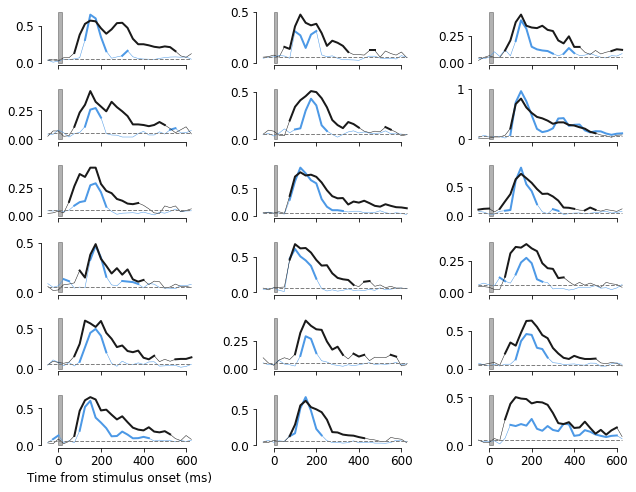

In [ ]:
t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50 # the plotted time bin is upper end of each interval
nperm = 2000
stimID = np.unique(df.StimID).astype(int)
single_stim = np.array(df.TrialID)>500 # Logical array locating stimuli presented in isolation
single_stim = single_stim & np.concatenate(([False],single_stim[:-1])) & (df.ItemID!=5)

surrogate_accuracy_RSVP = np.zeros((len(stimID),nperm,len(t)))
# create a surrogate accuracy traces from permuted label
# in stimuli presented inside a RSVP sequence
for n in tqdm(stimID): # independently for each stimulus class
    for i in range(nperm):   
        temp = Proba[(df.TrialID == 100)& (df.ItemID>1) & (df.ItemID<5) & (df.StimID == n),:]
        for j in range(temp.shape[0]):
            randperm = np.random.permutation(len(stimID))
            temp[j,:] = temp[j,randperm,:]
        temp2 = np.argmax(temp,axis = 1) == n
        surrogate_accuracy_RSVP[n,i,:] = np.mean(temp2, axis = 0)


surrogate_accuracy_single_stim = np.zeros((len(stimID),nperm,len(t)))

for n in tqdm(stimID):
    for i in range(nperm):   
        temp = Proba[single_stim & (df.StimID == n),:]
        for j in range(temp.shape[0]):
            randperm = np.random.permutation(len(stimID))
            temp[j,:] = temp[j,randperm,:]
        temp2 = np.argmax(temp,axis = 1) == n
        surrogate_accuracy_single_stim[n,i,:] = np.mean(temp2, axis = 0)
np.save('monkeyA_fake_hundred_mean_single_stim',surrogate_accuracy_single_stim)



## cluster correction    

significant_points_RSVP = np.zeros((len(stimID),len(t))).astype(bool)
for n in tqdm(stimID):
    # trained on hundreds
    hundreds = np.argmax(Proba[(df.TrialID == 100)& (df.ItemID>1) & (df.ItemID<5) & (df.StimID == n),:],axis = 1) == n
    real_data = np.mean(hundreds, axis = 0)
    pval_roi_threshold = 0.01
    pval_threshold = 0.001 
    significant_points_RSVP[n,:] = cluster_perm(real_data,surrogate_accuracy_RSVP[n,:],pval_roi_threshold,pval_threshold)

significant_points_single_stim = np.zeros((len(stimID),len(t))).astype(bool)

for n in tqdm(stimID):
    # trained on hundreds
    hundreds = np.argmax(Proba[single_stim & (df.StimID == n),:],axis = 1) == n
    real_data = np.mean(hundreds, axis = 0)
    pval_roi_threshold = 0.01
    pval_threshold = 0.001 
    significant_points_single_stim[n,:] = cluster_perm(real_data,surrogate_accuracy_single_stim[n,:],pval_roi_threshold,pval_threshold)  

## Draw the figure
lightblue = [0.3,0.6,0.9]
lightblack = [0.1,0.1,0.1]


fig,ax = plt.subplots(int(len(np.unique(df.StimID))/3),3,figsize = (9,7), sharey = False,sharex=True)
for n in np.unique(df.StimID).astype(int):
    # in RSVP
    hundreds = np.argmax(Proba[(df.TrialID == 100) & (df.ItemID<5) & (df.ItemID>1) & (df.StimID == n),:],axis = 1) == n
    ax[np.mod(n,6),n//6].plot(t,np.mean(hundreds, axis = 0), color = lightblue,linewidth=.5,label = 'in RSVP')
    cluster = label(significant_points_RSVP[n,:])
    for k in np.arange(1,max(cluster)+1):
        ax[np.mod(n,6),n//6].plot(t[cluster==k],np.mean(hundreds[:,cluster==k], axis = 0), color = lightblue,linewidth = 2)

    # in single stim
    hundreds = np.argmax(Proba[ single_stim & (df.StimID == n),:],axis = 1) == n
    ax[np.mod(n,6),n//6].plot(t,np.mean(hundreds, axis = 0), color = lightblack,linewidth=.5,label = 'isolates stim')
    cluster = label(significant_points_single_stim[n,:])
    for k in np.arange(1,max(cluster)+1):
        ax[np.mod(n,6),n//6].plot(t[cluster==k],np.mean(hundreds[:,cluster==k], axis = 0), color = lightblack,linewidth = 2)
    _,maxval = ax[np.mod(n,6),n//6].get_ylim()
    ax[np.mod(n,6),n//6].fill_between([0,16],[0,0],[maxval,maxval],color = 'k',alpha = 0.3)
    ax[np.mod(n,6),n//6].plot([t[0],t[-1]],[1/18,1/18],'--',color = [.5,.5,.5],linewidth = 1)
ax[-1,0].set_xticks([0,200,400,600])
ax[-1,0].set_xlabel('Time from stimulus onset (ms)')
sb.despine()
sb.despine(trim = True)
plt.tight_layout()
fig.savefig('Figure2.pdf')
fig.savefig('Figure2.jpg',dpi = 600)

##Figure 3 A and B

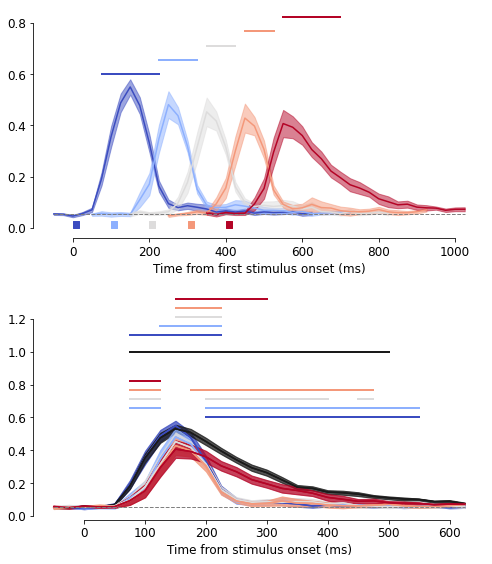

In [ ]:
t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50
coolwarm = cm.get_cmap('coolwarm')
colors = np.linspace(0,1,5)
colors = coolwarm(colors)

lightblue = [0.3,0.6,0.9]
lightblack = [0.1,0.1,0.1]
single_stim = np.array(df.TrialID)>500 # Logical array locating stimuli presented in isolation
single_stim = single_stim & np.concatenate(([False],single_stim[:-1]))

stims = np.unique(df.StimID).astype(int)
all_RSVP = np.zeros((len(stims),len(t)))
all_single = np.zeros((len(stims),len(t)))

fig,ax = plt.subplots(2,1,figsize = (7,8))

for it in range(5): # Loop through each position in the RSVP and single stimulus position to get average accuracy
    for n in stims: # Loop through each stimulus class
        # in RSVP
        if it == 4:
            hundreds = np.argmax(Proba[(df.ItemID == (it+1)) & (df.StimID == n),:],axis = 1) == n
        else:
            hundreds = np.argmax(Proba[ (df.TrialID == 100) & (df.ItemID == (it+1)) & (df.StimID == n),:],axis = 1) == n
        all_RSVP[n,:] = np.mean(hundreds, axis = 0)

        # in isolation
        if it == 0:
            # in single stim
            hundreds = np.argmax(Proba[ single_stim & (df.StimID == n),:],axis = 1) == n
            all_single[n,:] = np.mean(hundreds, axis = 0)

    all_RSVP_mean = np.mean(all_RSVP, axis = 0)
    all_RSVP_std = np.std(all_RSVP, axis = 0)
    high_bound = all_RSVP_mean+all_RSVP_std/np.sqrt(all_RSVP.shape[0])
    low_bound = all_RSVP_mean-all_RSVP_std/np.sqrt(all_RSVP.shape[0])

    ax[0].fill_between(t+it*100,high_bound,low_bound,color = colors[it],alpha = 0.5)
    ax[0].plot(t+it*100,np.mean(all_RSVP,axis = 0),color = colors[it]) 
    # VS chance stat
    corrected_stats = multipletests([stats.ttest_1samp(all_RSVP[:,x],1/18)[1] for x in range(len(t))], alpha=0.001, method='fdr_bh', is_sorted=False, returnsorted=False)
    clusters = label(corrected_stats[0])
    #print(it)
    for k in np.arange(1,max(clusters)+1):
        #print('last significant time :' + str(t[clusters==k][-1]))
        ax[1].plot(t[clusters==k],np.ones(sum(clusters==k))*it/18+1.1, color = colors[it],linewidth = 2) 
        ax[0].plot(t[clusters==k]+it*100,np.ones(sum(clusters==k))*it/18+.6, color = colors[it],linewidth = 2) 
    ax[1].fill_between(t,high_bound,low_bound,color = colors[it],alpha = 0.5)
    ax[1].plot(t,np.mean(all_RSVP,axis = 0),color = colors[it]) 

    # VS single stim stat

    corrected_stats = multipletests([stats.ttest_rel(all_RSVP[:,x],all_single[:,x])[1] for x in range(len(t))], alpha=0.001, method='fdr_bh', is_sorted=False, returnsorted=False)
    clusters = label(corrected_stats[0])
    for k in np.arange(1,max(clusters)+1):
        ax[1].plot(t[clusters==k],np.ones(sum(clusters==k))*it/18+.6, color = colors[it],linewidth = 2) 
    ax[1].fill_between(t,high_bound,low_bound,color = colors[it],alpha = 0.5)
    ax[1].plot(t,np.mean(all_RSVP,axis = 0),color = colors[it]) 
    #print('150 :')
    #print(corrected_stats[1][t ==150])
    #print('250 :')
    #print(corrected_stats[1][t ==250])
    if it == 0:
        all_single_mean = np.mean(all_single, axis = 0)
        all_single_std = np.std(all_single, axis = 0)
        high_bound = all_single_mean+all_single_std/np.sqrt(all_single_mean.shape[0])
        low_bound = all_single_mean-all_single_std/np.sqrt(all_single_mean.shape[0])
        ax[1].fill_between(t,high_bound,low_bound,color = lightblack,alpha = 0.5)
        ax[1].plot(t,all_single_mean,color = lightblack)
        corrected_stats = multipletests([stats.ttest_1samp(all_single[:,x],1/18)[1] for x in range(len(t))], alpha=0.001, method='fdr_bh', is_sorted=False, returnsorted=False)
        clusters = label(corrected_stats[0])
        for k in np.arange(1,max(clusters)+1):
            ax[1].plot(t[clusters==k],np.ones(sum(clusters==k))*it/18+1, color = lightblack,linewidth = 2) 
        ax[1].fill_between(t,high_bound,low_bound,color = lightblack,alpha = 0.5)
        ax[1].plot(t,all_single_mean,color = lightblack)  


    ax[0].fill_between(np.array([0,16])+it*100,[0,0],[1/36,1/36],color = colors[it])
ax[0].plot([t[0],t[-1]+it*100],[1/18,1/18],'--',color = [.5,.5,.5],linewidth = 1)
ax[1].plot([t[0],t[-1]],[1/18,1/18],'--',color = [.5,.5,.5],linewidth = 1)


    
ax[0].set_xlabel('Time from first stimulus onset (ms)')
ax[1].set_xticks([0,100,200,300,400,500,600])
ax[1].set_xlabel('Time from stimulus onset (ms)')
sb.despine()
sb.despine(trim = True)
plt.tight_layout()
fig.savefig('Figure3.pdf')
fig.savefig('Figure3.jpg',dpi = 600)



## Figure 4a

In [ ]:
# Generalization accuracy matrix
target = np.array(df.StimID).astype(int)[single_stim]
target = np.repeat(target[:,np.newaxis],28,axis = 1)
target = np.repeat(target[:,:,np.newaxis],28,axis = 2)

Full_proba_matrix_single_stim = Full_proba_matrix[single_stim,:]
generalization_accuracy = np.mean(np.argmax(Full_proba_matrix_single_stim,axis = 1)==target,axis = 0)
nperm = 2000
perm_generalization_accuracy = np.zeros((len(t),len(t),nperm))
print('Computing surrogate generalization matrices')
for i in tqdm(range(nperm)):
    randperm = np.random.permutation(len(target))
    temp_target = target[randperm,:]
    perm_generalization_accuracy[:,:,i] = np.mean(np.argmax(Full_proba_matrix_single_stim,axis = 1)==temp_target,axis = 0)
pvals = np.mean(np.repeat(generalization_accuracy[:,:,np.newaxis],nperm,axis = 2)<=perm_generalization_accuracy,axis = 2)
corrected_stats = multipletests(pvals.flatten(), alpha=0.001, method='fdr_bh', is_sorted=False, returnsorted=False)

100%|██████████| 2000/2000 [09:59<00:00,  3.34it/s]


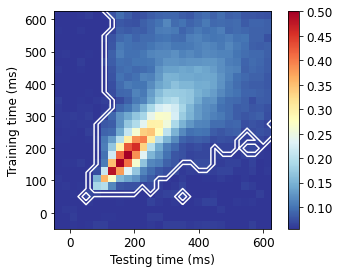

In [ ]:
fig,ax = plt.subplots(1,1)
im = ax.imshow(generalization_accuracy,origin='lower',extent=[t[0],t[-1],t[0],t[-1]],
                 cmap = 'RdYlBu_r',vmin = 1/18,vmax = 0.5)

fig.colorbar(im,ax=ax)

significant_map = np.reshape(corrected_stats[0],(len(t),len(t)))

ax.contour(significant_map,levels=1,extent=[t[0],t[-1],t[0],t[-1]],colors='w')

ax.set_xlabel('Testing time (ms)')
ax.set_ylabel('Training time (ms)')
fig.savefig('Figure4A.pdf')
fig.savefig('Figure4A.jpg',dpi = 600)

## Figure 4b

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


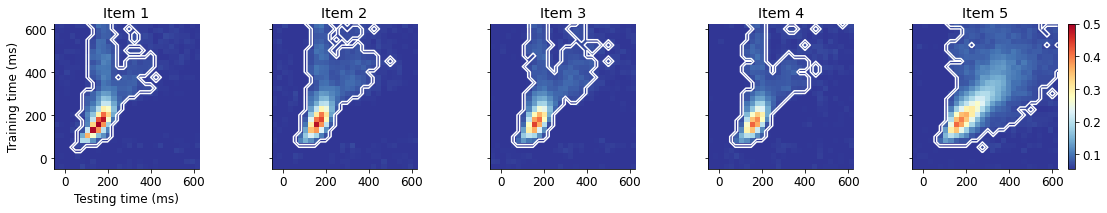

In [ ]:
t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50
significant_map = np.zeros((len(t),len(t),5))
generalization_accuracy = np.zeros((len(t),len(t),5))
for j in range(5):
    if j == 0:
         targ = ((df.ItemID==(j+1) ) & (df.TrialID == 100))
    else:
        targ = (df.ItemID==(j+1) )
    
    target = np.array(df.StimID).astype(int)[targ]
    target = np.repeat(target[:,np.newaxis],28,axis = 1)
    target = np.repeat(target[:,:,np.newaxis],28,axis = 2)

    Full_proba_matrix_RSVP = Full_proba_matrix[targ,:]
    generalization_accuracy[:,:,j] = np.mean(np.argmax(Full_proba_matrix_RSVP,axis = 1)==target,axis = 0)
    nperm = 2000
    perm_generalization_accuracy = np.zeros((len(t),len(t),nperm))
    for i in range(nperm):
        randperm = np.random.permutation(len(target))
        temp_target = target[randperm,:]
        perm_generalization_accuracy[:,:,i] = np.mean(np.argmax(Full_proba_matrix_RSVP,axis = 1)==temp_target,axis = 0)
    pvals = np.mean(np.repeat(generalization_accuracy[:,:,j][:,:,np.newaxis],nperm,axis = 2)<=perm_generalization_accuracy,axis = 2)
    
    corrected_stats = multipletests(pvals.flatten(), alpha=0.001, method='fdr_bh', is_sorted=False, returnsorted=False)
    significant_map[:,:,j] = np.reshape(corrected_stats[0],(len(t),len(t)))
#corrected_pvals = corrected_pvals[1].resize(len(t),len(t))


fig,ax = plt.subplots(1,5,figsize = (16,3),sharey = True)
for j in range(5):
    im = ax[j].imshow(generalization_accuracy[:,:,j],origin='lower',extent=[t[0],t[-1],t[0],t[-1]],
                    cmap = 'RdYlBu_r',vmin = 1/18,vmax = 0.5)
    ax[j].contour(significant_map[:,:,j],levels=1,extent=[t[0],t[-1],t[0],t[-1]],colors='w')
    ax[j].set_title('Item %d'%(j+1))
fig.colorbar(im,ax=ax[j])
ax[0].set_xlabel('Testing time (ms)')
ax[0].set_ylabel('Training time (ms)')
sb.despine()
plt.tight_layout()
fig.savefig('Figure4B.pdf')
fig.savefig('Figure4B.jpg',dpi = 600)

# Train with stims in the RSVP

In [9]:
compute_this_step = False # Set to false to just download the precomputed predictive probability of classifiers trained with RSVP stimuli

nstim = len(np.unique(df.StimID))

t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)

if compute_this_step:
    K = 10 # number of training folds
    nbins = len(t) # number of time bins
    sessions = np.unique(np.array(df.sesID).astype(int))

    # index
    training_stims = (np.array(df.TrialID)==100)  # select only stimuli presentation being followed by an other stimulus 100 ms after the onset
    training_stims = training_stims & np.concatenate(([False],training_stims[:-1])) # select only stimuli presentation being preceded by an other stimulus 100 ms before the onset
    
    print(sum(training_stims))

    X = Rc[:,np.mean(Rb[:,:,0],axis = 0)>1,:] # The firing rate
    Y = np.array(df.StimID).astype(int)
    ntr = X.shape[0]
    ntest = int(ntr/K)
    shuffle = np.random.permutation(ntr)# permutation of every trial
    Coef = np.zeros((nstim,X.shape[1],nbins,K) )# regression coefficient prealocation
    Proba = np.zeros((ntr,nstim,nbins))# predictive probability prealocation
    Full_proba_matrix = np.zeros((ntr,nstim,nbins,nbins)) # predictive probability prealocation
    corresponding_proba = np.zeros((ntr,nbins)) # predictive probability for concerned item prealocation
    for k in range(K):
        print('Fold ',k+1,' / ',K)
        testind = shuffle[k*ntest:(k+1)*ntest] # index of trial being tested
        if k == K-1:
            testind = shuffle[k*ntest:] 
        Ytest = Y[testind].astype(int)
        trainind = np.delete(shuffle,np.arange(k*ntest,(k+1)*ntest)) # index of trial being used for training
        trainind = trainind[training_stims[trainind]] # Keeping only long ISI 
        Xtrain = X[trainind,:]
        Ytrain = Y[trainind]

        for b in range(nbins):
            model = LogisticRegression(fit_intercept=False,solver='lbfgs',multi_class='auto',max_iter=10000).fit(Xtrain[:,:,b],Ytrain)
            Coef[:,:,b,k] = model.coef_
            Proba[testind,:,b] = model.predict_proba(X[testind,:,b])
            for b2 in range(nbins):
                Full_proba_matrix[testind,:,b,b2] = model.predict_proba(X[testind,:,b2])
            corresponding_proba[testind,b] = np.squeeze(Proba[testind,Ytest,b])
    np.save('monkeyA_PFC_trainRSVP_Coef.npy',Coef)# regression coefficient prealocation
    np.save('monkeyA_PFC_trainRSVP_Proba.npy',Proba) # predictive probability prealocation
    np.save('monkeyA_PFC_trainRSVP_Full_proba_matrix.npy',Full_proba_matrix) # predictive probability prealocation
    np.save('monkeyA_PFC_trainRSVP_corresponding_proba.npy',corresponding_proba) # predictive probability for concerned item prealocation
else:
    
    try:
        Coef = np.load('monkeyA_PFC_trainRSVP_Coef.npy')# regression coefficient prealocation
        Proba = np.load('monkeyA_PFC_trainRSVP_Proba.npy') # predictive probability prealocation
        Full_proba_matrix = np.load('monkeyA_PFC_trainRSVP_Full_proba_matrix.npy') # predictive probability prealocation
        corresponding_proba = np.load('monkeyA_PFC_trainRSVP_corresponding_proba.npy') # predictive probability for concerned item prealocation
    except:
        monkeyA_PFC_trainRSVP_Coef = 'https://ndownloader.figshare.com/files/27951414?private_link=203b69f9ea28fce41084'
        urllib.request.urlretrieve(monkeyA_PFC_trainRSVP_Coef,'monkeyA_PFC_trainRSVP_Coef.npy')
        monkeyA_PFC_trainRSVP_Proba = 'https://ndownloader.figshare.com/files/27951411?private_link=203b69f9ea28fce41084'
        urllib.request.urlretrieve(monkeyA_PFC_trainRSVP_Proba,'monkeyA_PFC_trainRSVP_Proba.npy')
        monkeyA_PFC_trainRSVP_Full_proba_matrix = 'https://ndownloader.figshare.com/files/27951405?private_link=203b69f9ea28fce41084'
        urllib.request.urlretrieve(monkeyA_PFC_trainRSVP_Full_proba_matrix,'monkeyA_PFC_trainRSVP_Full_proba_matrix.npy')
        monkeyA_PFC_trainRSVP_corresponding_proba = 'https://ndownloader.figshare.com/files/27951408?private_link=203b69f9ea28fce41084'
        urllib.request.urlretrieve(monkeyA_PFC_trainRSVP_corresponding_proba,'monkeyA_PFC_trainRSVP_corresponding_proba.npy')

        Coef = np.load('monkeyA_PFC_trainRSVP_Coef.npy')# regression coefficient prealocation
        Proba = np.load('monkeyA_PFC_trainRSVP_Proba.npy') # predictive probability prealocation
        Full_proba_matrix = np.load('monkeyA_PFC_trainRSVP_Full_proba_matrix.npy') # predictive probability prealocation
        corresponding_proba = np.load('monkeyA_PFC_trainRSVP_corresponding_proba.npy') # predictive probability for concerned item prealocation


## Figure 2 B

100%|██████████| 18/18 [00:19<00:00,  1.10s/it]


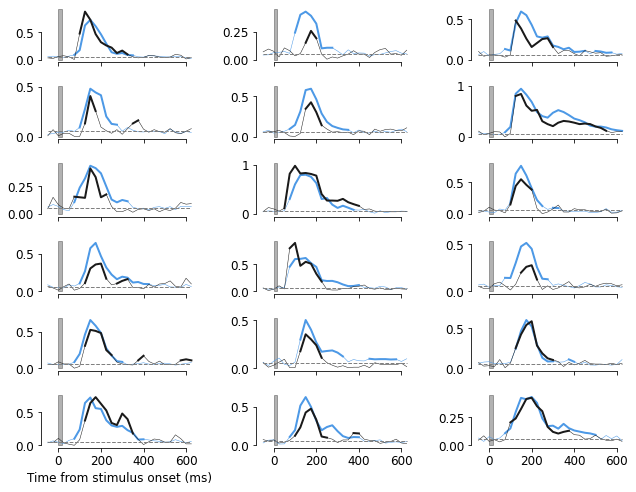

In [ ]:
t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50 # the plotted time bin is upper end of each interval
nperm = 2000
stimID = np.unique(df.StimID).astype(int)
single_stim = np.array(df.TrialID)>500 # Logical array locating stimuli presented in isolation
single_stim = single_stim & np.concatenate(([False],single_stim[:-1])) & (df.ItemID!=5)

surrogate_accuracy_RSVP = np.zeros((len(stimID),nperm,len(t)))
# create a surrogate accuracy traces from permuted label
# in stimuli presented inside a RSVP sequence
for n in tqdm(stimID): # independently for each stimulus class
    for i in range(nperm):   
        temp = Proba[(df.TrialID == 100)& (df.ItemID>1) & (df.ItemID<5) & (df.StimID == n),:]
        for j in range(temp.shape[0]):
            randperm = np.random.permutation(len(stimID))
            temp[j,:] = temp[j,randperm,:]
        temp2 = np.argmax(temp,axis = 1) == n
        surrogate_accuracy_RSVP[n,i,:] = np.mean(temp2, axis = 0)


surrogate_accuracy_single_stim = np.zeros((len(stimID),nperm,len(t)))

for n in tqdm(stimID):
    for i in range(nperm):   
        temp = Proba[single_stim & (df.StimID == n),:]
        for j in range(temp.shape[0]):
            randperm = np.random.permutation(len(stimID))
            temp[j,:] = temp[j,randperm,:]
        temp2 = np.argmax(temp,axis = 1) == n
        surrogate_accuracy_single_stim[n,i,:] = np.mean(temp2, axis = 0)


## cluster correction    

significant_points_RSVP = np.zeros((len(stimID),len(t))).astype(bool)
for n in tqdm(stimID):
    # trained on hundreds
    hundreds = np.argmax(Proba[(df.TrialID == 100)& (df.ItemID>1) & (df.ItemID<5) & (df.StimID == n),:],axis = 1) == n
    real_data = np.mean(hundreds, axis = 0)
    pval_roi_threshold = 0.01
    pval_threshold = 0.001 
    significant_points_RSVP[n,:] = cluster_perm(real_data,surrogate_accuracy_RSVP[n,:],pval_roi_threshold,pval_threshold)

significant_points_single_stim = np.zeros((len(stimID),len(t))).astype(bool)

for n in tqdm(stimID):
    # trained on hundreds
    hundreds = np.argmax(Proba[single_stim & (df.StimID == n),:],axis = 1) == n
    real_data = np.mean(hundreds, axis = 0)
    pval_roi_threshold = 0.01
    pval_threshold = 0.001 
    significant_points_single_stim[n,:] = cluster_perm(real_data,surrogate_accuracy_single_stim[n,:],pval_roi_threshold,pval_threshold)  

## Draw the figure
lightblue = [0.3,0.6,0.9]
lightblack = [0.1,0.1,0.1]


fig,ax = plt.subplots(int(len(np.unique(df.StimID))/3),3,figsize = (9,7), sharey = False,sharex=True)
for n in np.unique(df.StimID).astype(int):
    # in RSVP
    hundreds = np.argmax(Proba[(df.TrialID == 100) & (df.ItemID<5) & (df.ItemID>1) & (df.StimID == n),:],axis = 1) == n
    ax[np.mod(n,6),n//6].plot(t,np.mean(hundreds, axis = 0), color = lightblue,linewidth=.5,label = 'in RSVP')
    cluster = label(significant_points_RSVP[n,:])
    for k in np.arange(1,max(cluster)+1):
        ax[np.mod(n,6),n//6].plot(t[cluster==k],np.mean(hundreds[:,cluster==k], axis = 0), color = lightblue,linewidth = 2)

    # in single stim
    hundreds = np.argmax(Proba[ single_stim & (df.StimID == n),:],axis = 1) == n
    ax[np.mod(n,6),n//6].plot(t,np.mean(hundreds, axis = 0), color = lightblack,linewidth=.5,label = 'isolates stim')
    cluster = label(significant_points_single_stim[n,:])
    for k in np.arange(1,max(cluster)+1):
        ax[np.mod(n,6),n//6].plot(t[cluster==k],np.mean(hundreds[:,cluster==k], axis = 0), color = lightblack,linewidth = 2)
    _,maxval = ax[np.mod(n,6),n//6].get_ylim()
    ax[np.mod(n,6),n//6].fill_between([0,16],[0,0],[maxval,maxval],color = 'k',alpha = 0.3)
    ax[np.mod(n,6),n//6].plot([t[0],t[-1]],[1/18,1/18],'--',color = [.5,.5,.5],linewidth = 1)
ax[-1,0].set_xticks([0,200,400,600])
ax[-1,0].set_xlabel('Time from stimulus onset (ms)')
sb.despine()
sb.despine(trim = True)
plt.tight_layout()
fig.savefig('FigureS4A.pdf')
fig.savefig('FigureS4A.jpg',dpi = 600)

## Figure 3 C and D

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


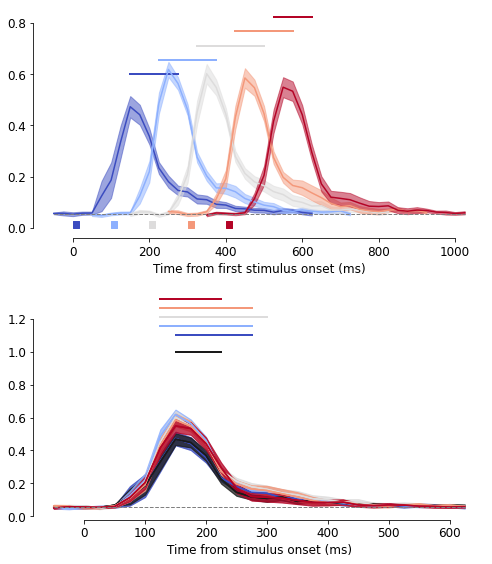

In [10]:
t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50 
coolwarm = cm.get_cmap('coolwarm')
colors = np.linspace(0,1,5)
colors = coolwarm(colors)

lightblue = [0.3,0.6,0.9]
lightblack = [0.1,0.1,0.1]
single_stim = np.array(df.TrialID)>500 # Logical array locating stimuli presented in isolation
single_stim = single_stim & np.concatenate(([False],single_stim[:-1]))

stims = np.unique(df.StimID).astype(int)
all_RSVP = np.zeros((len(stims),len(t)))
all_single = np.zeros((len(stims),len(t)))

fig,ax = plt.subplots(2,1,figsize = (7,8))

for it in range(5):
    for n in stims:
        # in RSVP
        if it == 4:
            hundreds = np.argmax(Proba[(df.ItemID == (it+1)) & (df.StimID == n),:],axis = 1) == n
        else:
            hundreds = np.argmax(Proba[ (df.TrialID == 100) & (df.ItemID == (it+1)) & (df.StimID == n),:],axis = 1) == n
        all_RSVP[n,:] = np.mean(hundreds, axis = 0)

        if it == 0:
            # in single stim
            hundreds = np.argmax(Proba[ single_stim & (df.StimID == n),:],axis = 1) == n
            all_single[n,:] = np.mean(hundreds, axis = 0)

    all_RSVP_mean = np.mean(all_RSVP, axis = 0)
    all_RSVP_std = np.std(all_RSVP, axis = 0)
    high_bound = all_RSVP_mean+all_RSVP_std/np.sqrt(all_RSVP.shape[0])
    low_bound = all_RSVP_mean-all_RSVP_std/np.sqrt(all_RSVP.shape[0])

    ax[0].fill_between(t+it*100,high_bound,low_bound,color = colors[it],alpha = 0.5)
    ax[0].plot(t+it*100,np.mean(all_RSVP,axis = 0),color = colors[it]) 
    # VS chance stat
    corrected_stats = multipletests([stats.ttest_1samp(all_RSVP[:,x],1/18)[1] for x in range(len(t))], alpha=0.001, method='fdr_bh', is_sorted=False, returnsorted=False)
    clusters = label(corrected_stats[0])
    #print(it)
    for k in np.arange(1,max(clusters)+1):
        #print('last significant time :' + str(t[clusters==k][-1]))
        ax[1].plot(t[clusters==k],np.ones(sum(clusters==k))*it/18+1.1, color = colors[it],linewidth = 2) 
        ax[0].plot(t[clusters==k]+it*100,np.ones(sum(clusters==k))*it/18+.6, color = colors[it],linewidth = 2) 
    ax[1].fill_between(t,high_bound,low_bound,color = colors[it],alpha = 0.5)
    ax[1].plot(t,np.mean(all_RSVP,axis = 0),color = colors[it]) 

    # VS single stim stat

    corrected_stats = multipletests([stats.ttest_rel(all_RSVP[:,x],all_single[:,x])[1] for x in range(len(t))], alpha=0.001, method='fdr_bh', is_sorted=False, returnsorted=False)
    clusters = label(corrected_stats[0])
    
    for k in np.arange(1,max(clusters)+1):
        
        ax[1].plot(t[clusters==k],np.ones(sum(clusters==k))*it/18+.6, color = colors[it],linewidth = 2) 
    
    ax[1].fill_between(t,high_bound,low_bound,color = colors[it],alpha = 0.5)
    ax[1].plot(t,np.mean(all_RSVP,axis = 0),color = colors[it]) 
    
    #print('150 :')
    #print(corrected_stats[1][t ==150])
    #print('250 :')
    #print(corrected_stats[1][t ==250])
    if it == 0:
        all_single_mean = np.mean(all_single, axis = 0)
        all_single_std = np.std(all_single, axis = 0)
        high_bound = all_single_mean+all_single_std/np.sqrt(all_single_mean.shape[0])
        low_bound = all_single_mean-all_single_std/np.sqrt(all_single_mean.shape[0])
        ax[1].fill_between(t,high_bound,low_bound,color = lightblack,alpha = 0.5)
        ax[1].plot(t,all_single_mean,color = lightblack)
        corrected_stats = multipletests([stats.ttest_1samp(all_single[:,x],1/18)[1] for x in range(len(t))], alpha=0.001, method='fdr_bh', is_sorted=False, returnsorted=False)
        clusters = label(corrected_stats[0])
        for k in np.arange(1,max(clusters)+1):
            ax[1].plot(t[clusters==k],np.ones(sum(clusters==k))*it/18+1, color = lightblack,linewidth = 2) 
        ax[1].fill_between(t,high_bound,low_bound,color = lightblack,alpha = 0.5)
        ax[1].plot(t,all_single_mean,color = lightblack) 


    ax[0].fill_between(np.array([0,16])+it*100,[0,0],[1/36,1/36],color = colors[it])
ax[0].plot([t[0],t[-1]+it*100],[1/18,1/18],'--',color = [.5,.5,.5],linewidth = 1)
ax[1].plot([t[0],t[-1]],[1/18,1/18],'--',color = [.5,.5,.5],linewidth = 1)


    
ax[0].set_xlabel('Time from first stimulus onset (ms)')
ax[1].set_xticks([0,100,200,300,400,500,600])
ax[1].set_xlabel('Time from stimulus onset (ms)')
sb.despine()
sb.despine(trim = True)
plt.tight_layout()
fig.savefig('Figure3CD.pdf')
fig.savefig('Figure3CD.jpg',dpi = 600)



In [11]:
target = np.array(df.StimID).astype(int)[single_stim]
target = np.repeat(target[:,np.newaxis],28,axis = 1)
target = np.repeat(target[:,:,np.newaxis],28,axis = 2)

Full_proba_matrix_single_stim = Full_proba_matrix[single_stim,:]
generalization_accuracy = np.mean(np.argmax(Full_proba_matrix_single_stim,axis = 1)==target,axis = 0)
nperm = 2000
perm_generalization_accuracy = np.zeros((len(t),len(t),nperm))
for i in tqdm(range(nperm)):
    randperm = np.random.permutation(len(target))
    temp_target = target[randperm,:]
    perm_generalization_accuracy[:,:,i] = np.mean(np.argmax(Full_proba_matrix_single_stim,axis = 1)==temp_target,axis = 0)
pvals = np.mean(np.repeat(generalization_accuracy[:,:,np.newaxis],nperm,axis = 2)<=perm_generalization_accuracy,axis = 2)
corrected_stats = multipletests(pvals.flatten(), alpha=0.001, method='fdr_bh', is_sorted=False, returnsorted=False)

100%|██████████| 2000/2000 [08:36<00:00,  3.87it/s]


## Figure 4 C

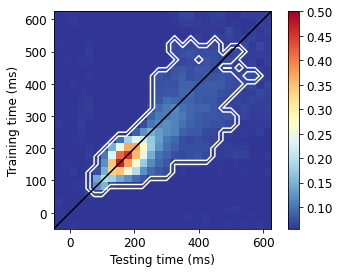

In [12]:
fig,ax = plt.subplots(1,1)
im = ax.imshow(generalization_accuracy,origin='lower',extent=[t[0],t[-1],t[0],t[-1]],
                 cmap = 'RdYlBu_r',vmin = 1/18,vmax = 0.5)

fig.colorbar(im,ax=ax)

significant_map = np.reshape(corrected_stats[0],(len(t),len(t)))

ax.contour(significant_map,levels=1,extent=[t[0],t[-1],t[0],t[-1]],colors='w')
plt.plot([t[0],t[-1]],[t[0],t[-1]],'k')
ax.set_xlabel('Testing time (ms)')
ax.set_ylabel('Training time (ms)')
fig.savefig('Figure4C.pdf')
fig.savefig('Figure4C.jpg',dpi = 600)

## Figure 4 D

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


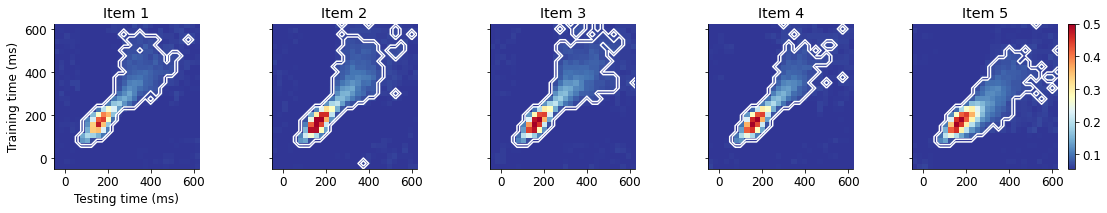

In [13]:
significant_map = np.zeros((len(t),len(t),5))
generalization_accuracy = np.zeros((len(t),len(t),5))
for j in range(5):
    if j == 0:
         targ = ((df.ItemID==(j+1) ) & (df.TrialID == 100))
    else:
        targ = (df.ItemID==(j+1) )
    
    target = np.array(df.StimID).astype(int)[targ]
    target = np.repeat(target[:,np.newaxis],28,axis = 1)
    target = np.repeat(target[:,:,np.newaxis],28,axis = 2)

    Full_proba_matrix_RSVP = Full_proba_matrix[targ,:]
    generalization_accuracy[:,:,j] = np.mean(np.argmax(Full_proba_matrix_RSVP,axis = 1)==target,axis = 0)
    nperm = 2000
    perm_generalization_accuracy = np.zeros((len(t),len(t),nperm))
    for i in range(nperm):
        randperm = np.random.permutation(len(target))
        temp_target = target[randperm,:]
        perm_generalization_accuracy[:,:,i] = np.mean(np.argmax(Full_proba_matrix_RSVP,axis = 1)==temp_target,axis = 0)
    pvals = np.mean(np.repeat(generalization_accuracy[:,:,j][:,:,np.newaxis],nperm,axis = 2)<=perm_generalization_accuracy,axis = 2)
    
    corrected_stats = multipletests(pvals.flatten(), alpha=0.001, method='fdr_bh', is_sorted=False, returnsorted=False)
    significant_map[:,:,j] = np.reshape(corrected_stats[0],(len(t),len(t)))
#corrected_pvals = corrected_pvals[1].resize(len(t),len(t))


fig,ax = plt.subplots(1,5,figsize = (16,3),sharey = True)
for j in range(5):
    im = ax[j].imshow(generalization_accuracy[:,:,j],origin='lower',extent=[t[0],t[-1],t[0],t[-1]],
                    cmap = 'RdYlBu_r',vmin = 1/18,vmax = 0.5)
    ax[j].contour(significant_map[:,:,j],levels=1,extent=[t[0],t[-1],t[0],t[-1]],colors='w')
    ax[j].set_title('Item %d'%(j+1))
fig.colorbar(im,ax=ax[j])
ax[0].set_xlabel('Testing time (ms)')
ax[0].set_ylabel('Training time (ms)')
sb.despine()
plt.tight_layout()
fig.savefig('Figure4D.pdf')
fig.savefig('Figure4D.jpg',dpi = 600)

# Dropping channels out from analysis

In [ ]:
recompute_this_step = True # Set to false to just download the precomputed predictive probabilities

stims = np.unique(df.StimID).astype(int)
nstim = len(stims)

t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50
tested_times = [75,150,300]
tested_prop = [.05,.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95,1]

# Sorting channels according to the absolute value of the coefficients after training
try:
    Coef = np.load('monkeyA_PFC_trainsingle_Coef.npy')
except:
    monkeyA_PFC_trainsingle_Coef = 'https://ndownloader.figshare.com/files/28216620?private_link=203b69f9ea28fce41084'
    urllib.request.urlretrieve(monkeyA_PFC_trainsingle_Coef,'monkeyA_PFC_trainsingle_Coef.npy')
    Coef = np.load('monkeyA_PFC_trainsingle_Coef.npy')

# Sort coefficients
abs_coef = np.mean(abs(np.mean(Coef,axis = 3)),axis = 0)
arg_sorted_coeffs = np.argsort(abs_coef,axis = 0)


# index
single_stim = (np.array(df.TrialID)>499)  # select only stimuli presentation being followed by an other stimulus 400 ms after the onset
single_stim = single_stim & np.concatenate(([False],single_stim[:-1])) # select only stimuli presentation being preceded by an other stimulus 400 ms before the onset

# Prealocation of the accuracy for all conditions
chan_dependent_accuracy_best = np.zeros((len(tested_times),len(tested_prop),nstim))
chan_dependent_accuracy_worst = np.zeros((len(tested_times),len(tested_prop),nstim))
Y = np.array(df.StimID).astype(int)

if recompute_this_step:
    K = 10 # number of training folds
    nbins = len(t) # number of time bins
    sessions = np.unique(np.array(df.sesID).astype(int))

    print(sum(single_stim))
    
    X = Rc[:,np.mean(Rb[:,:,0],axis = 0)>1,:] # The firing rate
    for tt,testime in tqdm(enumerate(tested_times)):
        best_chans = np.squeeze(arg_sorted_coeffs[:,np.where(t == testime)[0]])
        worst_chans = np.flip(best_chans)
        for tp,testprop in enumerate(tested_prop):
            
            Xbest = X[:,best_chans[:np.round(testprop * len(best_chans)).astype(int)],:]
            Xworst = X[:,worst_chans[:np.round(testprop * len(worst_chans)).astype(int)],:]
            Xbest = np.squeeze(Xbest[:,:,np.where(t == testime)[0]])
            Xworst = np.squeeze(Xworst[:,:,np.where(t == testime)[0]])
            
            ntr = X.shape[0]
            ntest = int(ntr/K)
            shuffle = np.random.permutation(ntr)# permutation of every trial
            
            Probabest = np.zeros((ntr,nstim))# predictive probability prealocation
            Probaworst = np.zeros((ntr,nstim))# predictive probability prealocation
            for k in range(K):
                testind = shuffle[k*ntest:(k+1)*ntest] # index of trial being tested
                if k == K-1:
                    testind = shuffle[k*ntest:] 
                Ytest = Y[testind].astype(int)
                trainind = np.delete(shuffle,np.arange(k*ntest,(k+1)*ntest)) # index of trial being used for training
                trainind = trainind[single_stim[trainind]] # Keeping only long ISI 
                Ytrain = Y[trainind]
                
                Xtrain = Xbest[trainind,:]
                model = LogisticRegression(fit_intercept=False,solver='lbfgs',multi_class='auto',max_iter=10000).fit(Xtrain,Ytrain)
                Probabest[testind,:] = model.predict_proba(Xbest[testind,:])
                
                Xtrain = Xworst[trainind,:]
                model = LogisticRegression(fit_intercept=False,solver='lbfgs',multi_class='auto',max_iter=10000).fit(Xtrain,Ytrain)
                Probaworst[testind,:] = model.predict_proba(Xworst[testind,:])
            accuraciesbest = np.zeros(nstim)
            accuraciesworst = np.zeros(nstim)
            for n in stims:
                accuraciesbest[n] = np.mean(np.argmax(Probabest[single_stim & (df.StimID == n),:],axis = 1) == n)
                accuraciesworst[n] = np.mean(np.argmax(Probaworst[single_stim & (df.StimID == n),:],axis = 1) == n)
            chan_dependent_accuracy_best[tt,tp,:]= accuraciesbest
            chan_dependent_accuracy_worst[tt,tp,:]= accuraciesworst
    np.save('chan_dependent_accuracy_best.npy',chan_dependent_accuracy_best)
    np.save('chan_dependent_accuracy_worst.npy',chan_dependent_accuracy_worst)    
else:
    chan_dependent_accuracy_best = np.load('chan_dependent_accuracy_best.npy')
    chan_dependent_accuracy_worst = np.load('chan_dependent_accuracy_worst.npy')

## Figure S6

In [ ]:
tested_prop = np.array(tested_prop)
fig,ax = plt.subplots(1,chan_dependent_accuracy_best.shape[0],figsize = (6,3),sharex = True,sharey = True)
for i in range(chan_dependent_accuracy_best.shape[0]):
    high_bound = np.mean(chan_dependent_accuracy_best[i,:],axis = 1)+np.std(chan_dependent_accuracy_best[i,:],axis = 1)/np.sqrt(nstim)
    low_bound = np.mean(chan_dependent_accuracy_best[i,:],axis = 1)-np.std(chan_dependent_accuracy_best[i,:],axis = 1)/np.sqrt(nstim)
    ax[i].fill_between(tested_prop,high_bound,low_bound,color = 'r',alpha = 0.5)
    ax[i].plot(tested_prop,np.mean(chan_dependent_accuracy_best[i,:],axis = 1),'r')
    corrected_stats = multipletests([stats.ttest_1samp(chan_dependent_accuracy_best[i,x,:],1/18)[1] for x in range(len(tested_prop))], alpha=0.01, method='fdr_bh', is_sorted=False, returnsorted=False)
    clusters = label(corrected_stats[0])
    for k in np.arange(1,max(clusters)+1):
        ax[i].plot(tested_prop[clusters==k],np.ones(sum(clusters==k))*.6, color = 'r',linewidth = 2) 
    print('At '+str(tested_times[i])+ ' ms,'+
          'the ' +str(np.round(100*tested_prop[np.where(corrected_stats[0])[0][0]]).astype(int))+'% worst channels are necessary for above chance decoding')
    
    high_bound = np.mean(chan_dependent_accuracy_worst[i,:],axis = 1)+np.std(chan_dependent_accuracy_worst[i,:],axis = 1)/np.sqrt(nstim)
    low_bound = np.mean(chan_dependent_accuracy_worst[i,:],axis = 1)-np.std(chan_dependent_accuracy_worst[i,:],axis = 1)/np.sqrt(nstim)
    ax[i].fill_between(tested_prop,high_bound,low_bound,color = 'g',alpha = 0.5)
    ax[i].plot(tested_prop,np.mean(chan_dependent_accuracy_worst[i,:],axis = 1),'g')
    corrected_stats = multipletests([stats.ttest_1samp(chan_dependent_accuracy_worst[i,x,:],1/18)[1] for x in range(len(tested_prop))], alpha=0.01, method='fdr_bh', is_sorted=False, returnsorted=False)
    clusters = label(corrected_stats[0])
    for k in np.arange(1,max(clusters)+1):
        ax[i].plot(tested_prop[clusters==k],np.ones(sum(clusters==k))*.7, color = 'g',linewidth = 2)
    print('At '+str(tested_times[i])+ ' ms,'+
          'the ' +str(np.round(100*tested_prop[np.where(corrected_stats[0])[0][0]]).astype(int))+'% best channels are sufficient for above chance decoding')
    
    
    ax[i].plot(tested_prop,np.ones_like(tested_prop)*1/18,'--k')
    ax[i].set_title('t = ' + str(tested_times[i]) + ' ms')
ax[0].set_xlabel('Proportion of channel kept')   
ax[0].set_ylabel('Accuracy')   
sb.despine()
plt.tight_layout()
fig.savefig('FigureS6.pdf')
fig.savefig('FigureS6.jpg',dpi = 600)